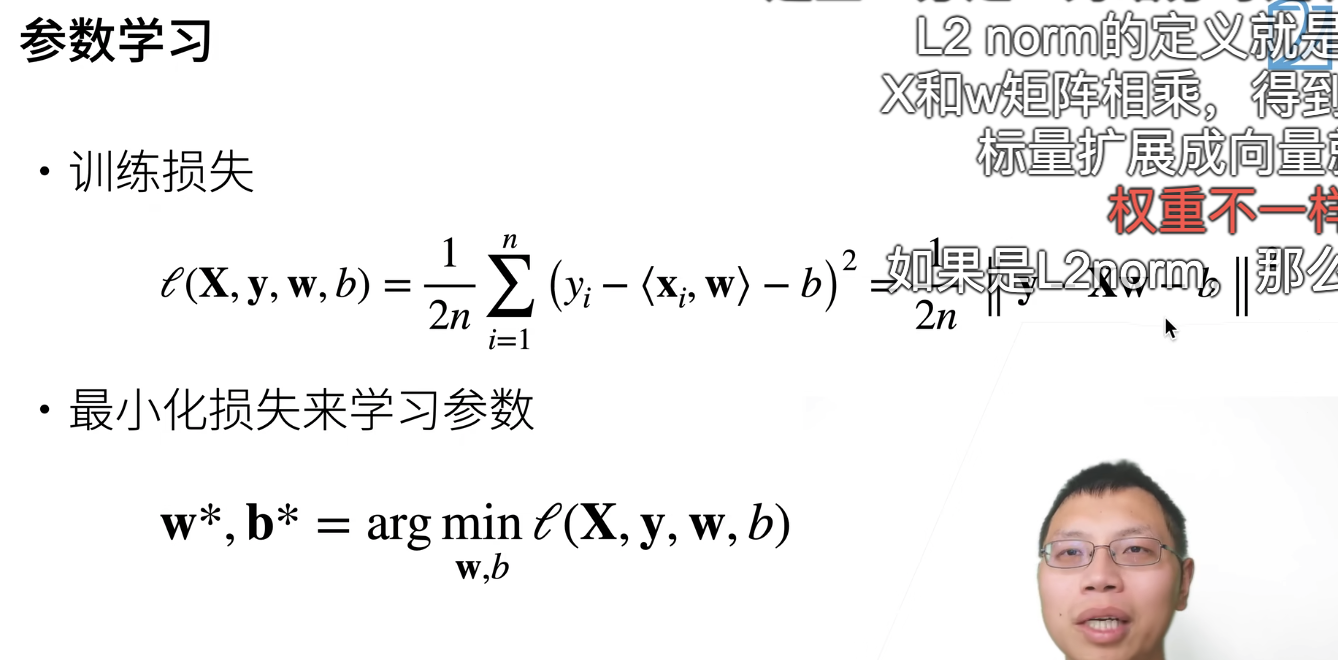

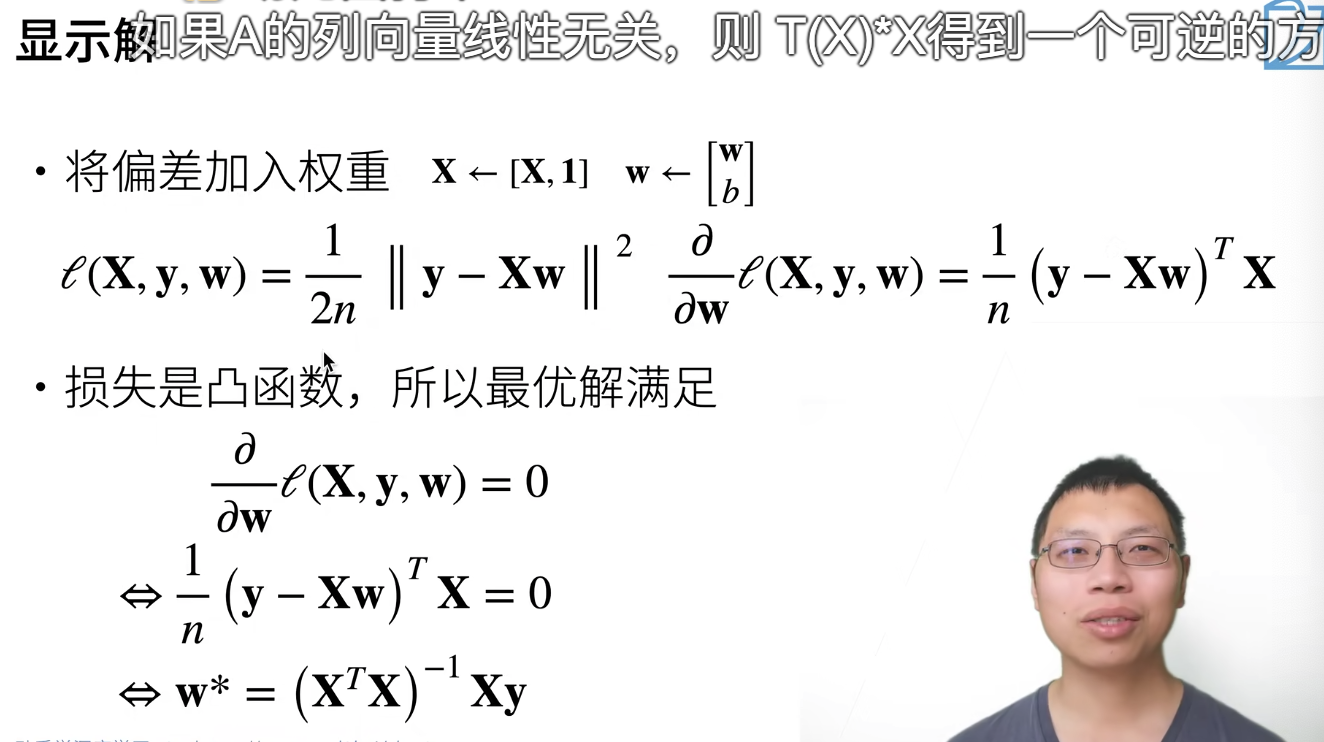

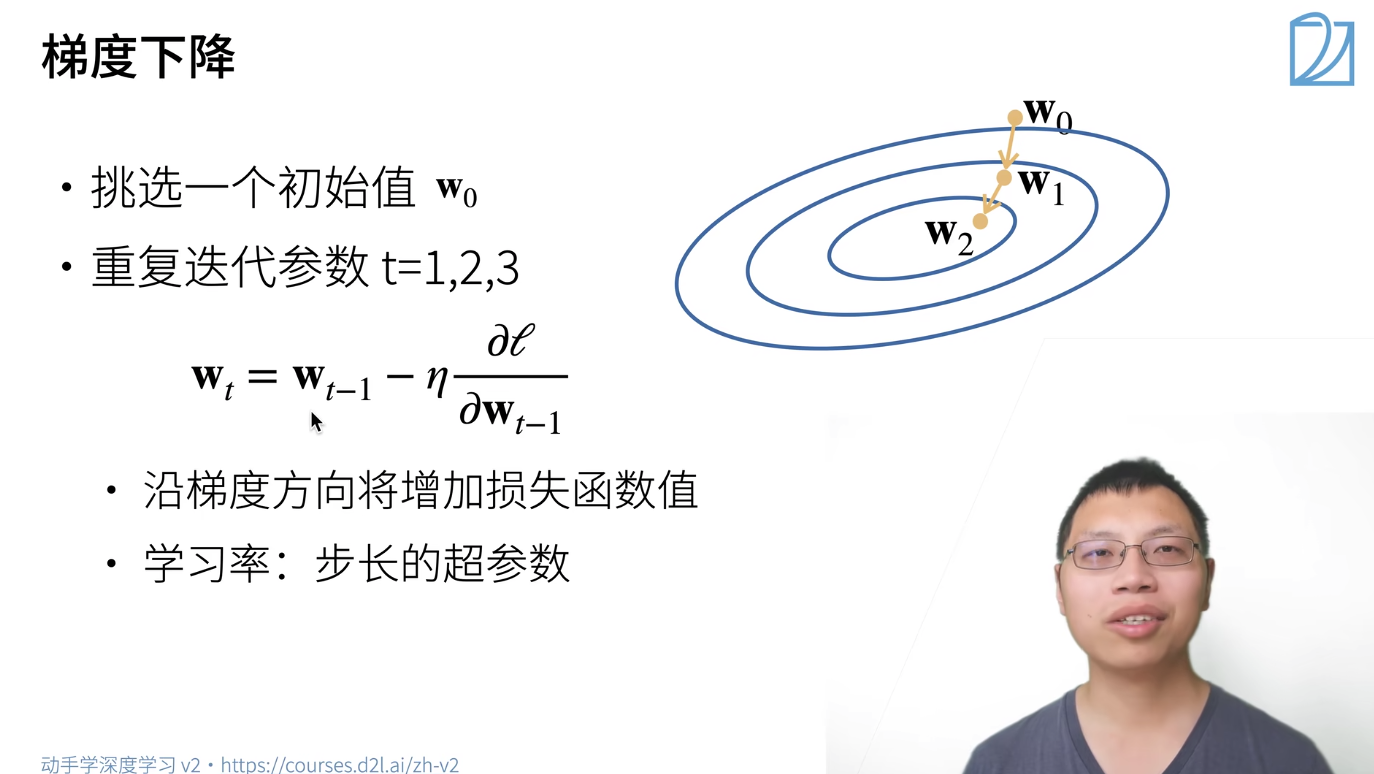

In [2]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

In [4]:
def synthetic_data(w, b, num_example):
    X = torch.normal(0,1,(num_example,len(w)))
    y =torch.matmul(X, w)+b
    y += torch.normal(0,0.01,y.shape)
    return X,y.reshape((-1,1))
true_w = torch.tensor([2,-3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [11]:
features.size()

torch.Size([1000, 2])

In [12]:
labels.size()

torch.Size([1000, 1])

In [6]:
print("features:", features[0], "\nlabel:", labels[0])

features: tensor([-0.4645, -0.9818]) 
label: tensor([6.6092])


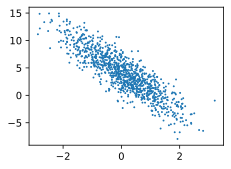

In [14]:
d2l.set_figsize() # detach 从计算图里detach出来
d2l.plt.scatter(features[:,1].detach().numpy(), labels.detach().numpy(), 1)

In [15]:
def data_iter(batch_size, features,labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)
    for i in range(0, num_examples,batch_size):
        batch_indices = torch.tensor(
            indices[i:min(i+batch_size,num_examples)]
        )
        yield features[batch_indices], labels[batch_indices]
batch_size = 10
for X,y in data_iter(batch_size, features, labels):
    print(X, "\n", y)
    break

tensor([[-0.8082, -0.1297],
        [ 0.2171,  0.9266],
        [-1.3049,  1.0459],
        [ 0.1667, -0.1923],
        [ 1.7362, -1.2310],
        [-0.2015,  0.6033],
        [ 0.2645,  0.0694],
        [-0.1930, -0.8734],
        [ 0.6779, -0.7253],
        [ 0.6763,  0.4654]]) 
 tensor([[ 3.0212],
        [ 1.4818],
        [-1.9683],
        [ 5.1867],
        [11.8462],
        [ 1.7442],
        [ 4.4832],
        [ 6.7776],
        [ 8.0455],
        [ 3.9635]])


## 参数初始化

In [35]:
w = torch.normal(0, 0.01, size=(2,1),requires_grad=True)

In [36]:
b = torch.zeros(1, requires_grad=True)

In [37]:
def linreq(X, w, b):
    return torch.matmul(X,w) + b

In [38]:
def squared_loss(y_hat, y):
    return (y_hat-y.reshape(y_hat.shape))**2/2

In [39]:
def sgd(params, lr, batch_size): # 
    # lr 学习率 # params 就是w batch_size 批次
    with torch.no_grad(): # torch.no_grad() 确保在 with 语句块内的所有计算都不会跟踪梯度信息，从而提高运行效率。
        for param in params:
            param -= lr * param.grad/batch_size # 这里除以 batch_size 是因为我们通常在批量（batch）模式下计算梯度，而每个批量内的梯度实际上是所有样本梯度的平均值。除以 batch_size 可以确保更新的步长与实际梯度一致。
            param.grad.zero_() # 每次梯度归零

In [40]:
lr=0.03
num_epochs = 3
net = linreq
loss =squared_loss

with torch.no_grad():
    train_l = loss(net(features,w,b),labels)
    print(f"epoch0, loss{float(train_l.mean()):f}")

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X,w,b),y)
        # 因为l形状是batch_size,1,而不是一个标量，l中的所有元素加到一个标量，并以此计算w，b的梯度
        l.sum().backward()
        sgd([w, b],lr, batch_size) # 使用参数的梯度更新模型
    with torch.no_grad():
        train_l = loss(net(features,w,b),labels)
        print(f"epoch{epoch+1}, loss{float(train_l.mean()):f}")

epoch0, loss15.856674
epoch1, loss0.044939
epoch2, loss0.000185
epoch3, loss0.000054


In [41]:
print(f"差值: {true_w - w.reshape(true_w.shape)}")

差值: tensor([ 0.0010, -0.0007], grad_fn=<SubBackward0>)


In [42]:
print(f"差值: {true_b - b}")

差值: tensor([0.0002], grad_fn=<RsubBackward1>)


# 简介实现

In [43]:
import numpy as np
import torch
from torch.utils import data
from d2l import torch as d2l

In [44]:
true_w = torch.tensor([2,-3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [45]:
def load_array(data_arrays, batch_size, is_train=True):
    # 构造一个pytorch数据迭代器
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset,batch_size,shuffle=is_train)

In [47]:
batch_size =10
data_iter = load_array((features,labels),batch_size)

In [48]:
next(iter(data_iter))

[tensor([[-0.2122,  0.0499],
         [-1.4619, -0.1843],
         [-1.4832,  0.4885],
         [ 0.8109,  0.8312],
         [-1.0365,  0.1374],
         [ 0.3641, -0.0806],
         [ 1.2363, -0.5397],
         [ 0.4167, -0.4298],
         [-1.0314, -1.0975],
         [ 0.1227,  0.3249]]),
 tensor([[ 3.5835],
         [ 1.9195],
         [-0.4054],
         [ 3.0026],
         [ 1.6520],
         [ 5.1949],
         [ 8.4859],
         [ 6.4795],
         [ 5.8645],
         [ 3.3475]])]

In [49]:
from torch import nn
net = nn.Sequential(nn.Linear(2,1)) # 输入2，输出1，Sequential是容器

In [51]:
net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0) # net[0]是Sequential容器的第一个层

tensor([0.])

In [52]:
loss = nn.MSELoss()

In [53]:
trainer = torch.optim.SGD(net.parameters(), lr=0.03)

In [54]:
num_epochs = 3
for epoch in range(num_epochs):
    for X,y in data_iter:
        l= loss(net(X),y)
        trainer.zero_grad() # 消除梯度
        l.backward()
        trainer.step() # 这个就是模型更新
    l=loss(net(features),labels)
    print(f'epoch{epoch+1},loss{l:f}')
        

epoch1,loss0.000197
epoch2,loss0.000108
epoch3,loss0.000108
